#Task IX: Kolmogorov-Arnold Network
Implement a classical Kolmogorov-Arnold Network using basis-splines or some other KAN architecture and apply it to MNIST. Show its performance on the test data. Comment on potential ideas to extend this classical KAN architecture to a quantum KAN and sketch out the architecture in detail.


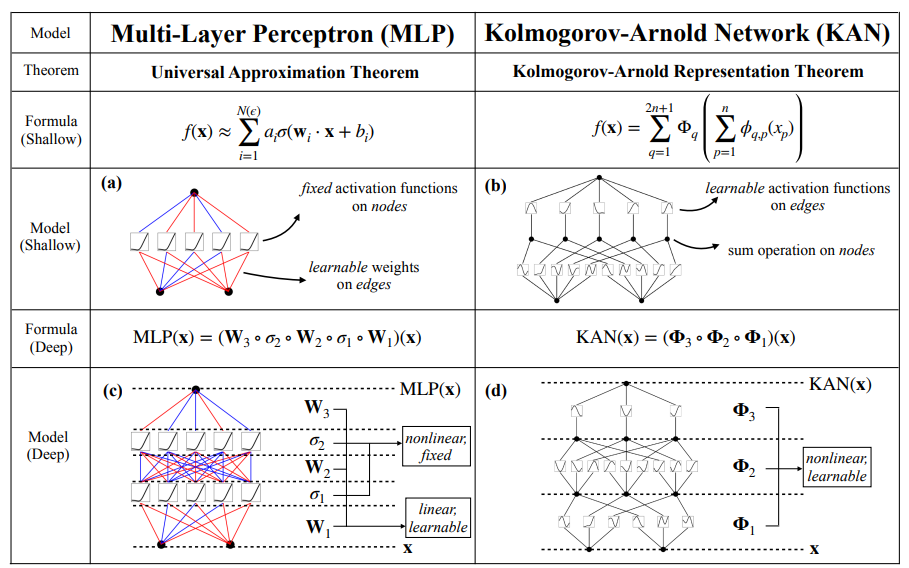

#Fourier Kolmogorov-Arnold Networks (KANs)
Kolmogorov-Arnold Networks are neural networks inspired by the Kolmogorov-Arnold representation theorem, which states that any multivariate continuous function can be represented using a finite sum of one-dimensional functions. The Fourier KAN leverages this concept using Fourier series expansions to approximate complex functions.

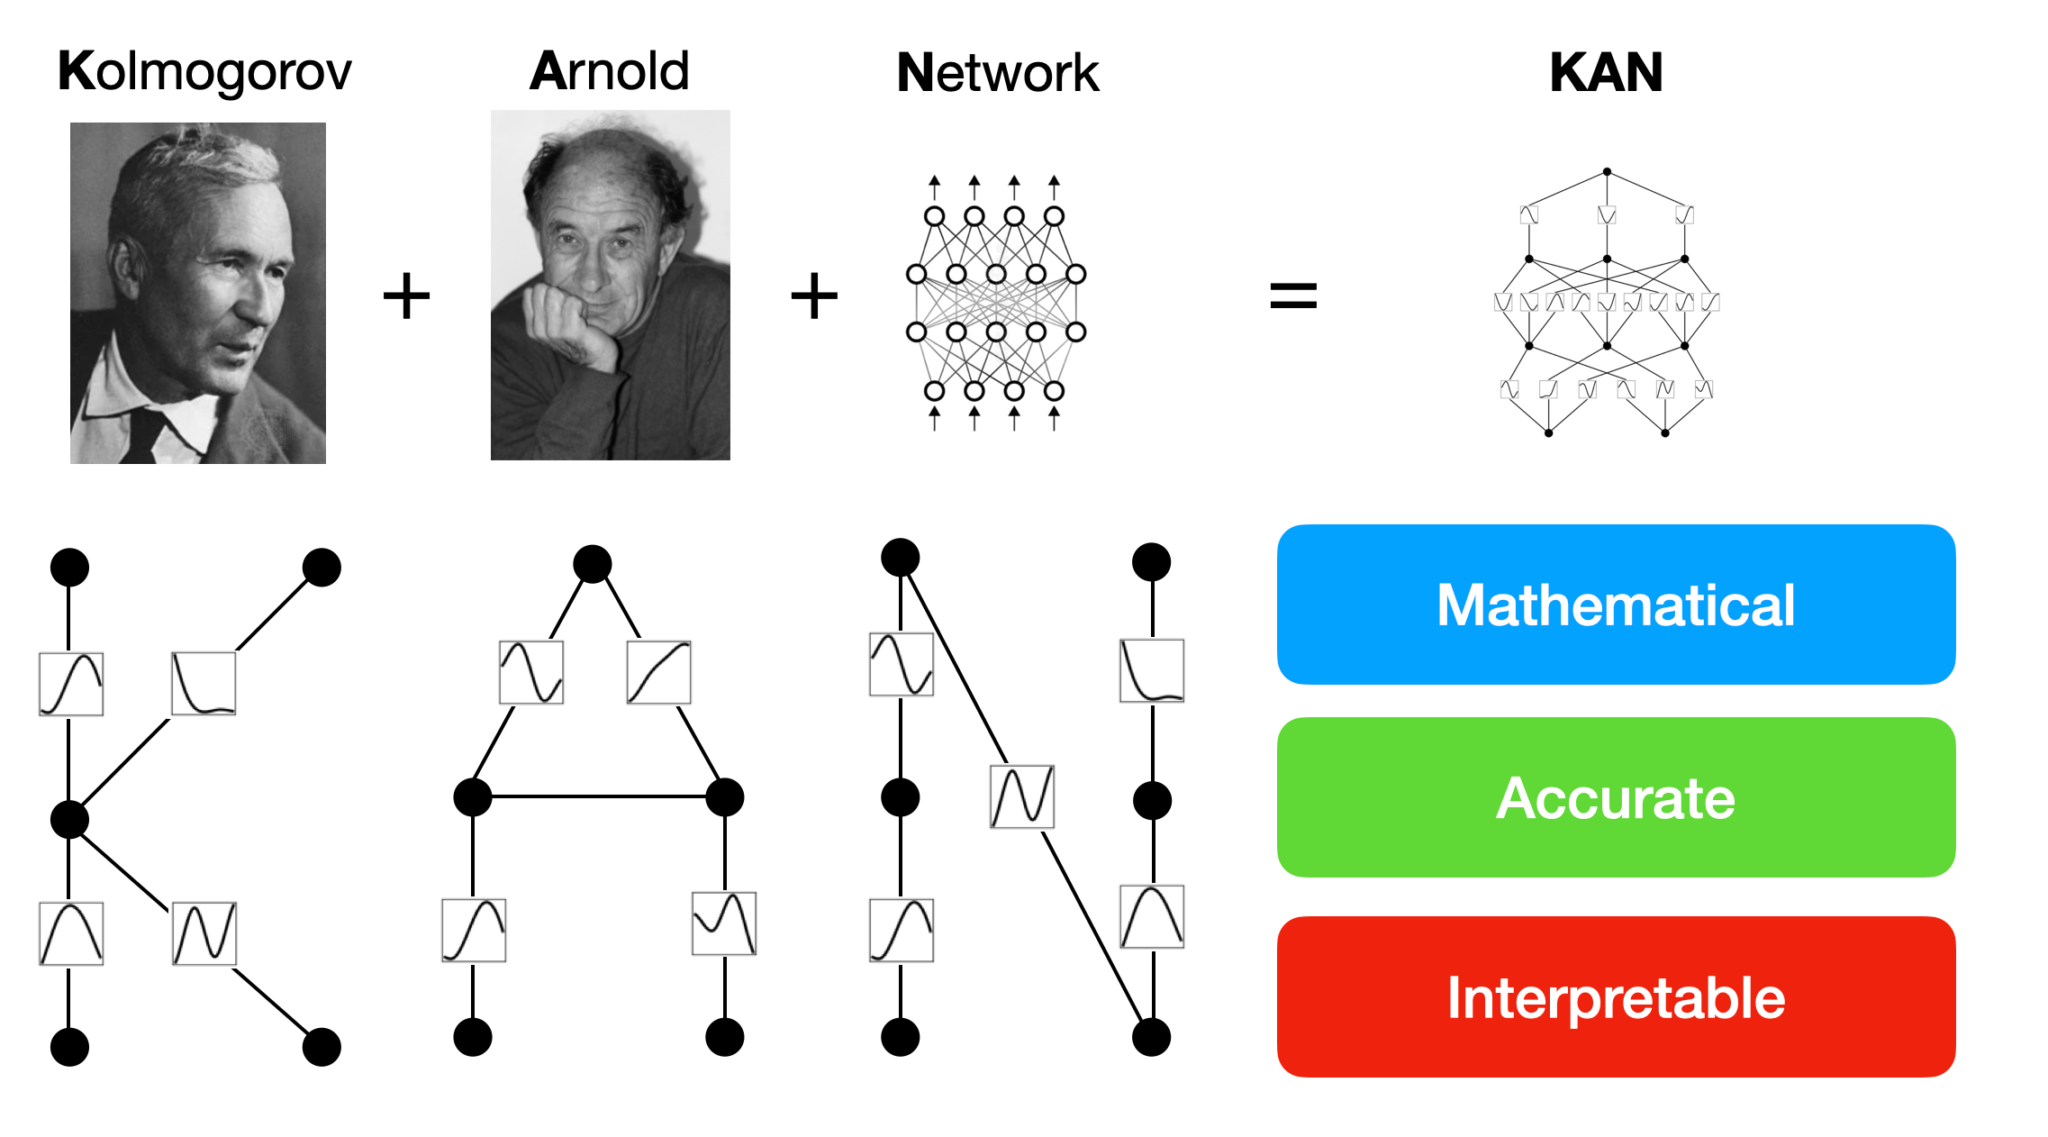

#Import Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt


#Naive Fourier KAN Layer
The NaiveFourierKANLayer is a custom layer that applies a Fourier series expansion to its input. Instead of traditional linear transformations, it uses sine and cosine functions to model non-linear patterns.

In [2]:
class NaiveFourierKANLayer(nn.Module):
    def __init__(self, inputdim, outdim, initial_gridsize, addbias=True):
        super(NaiveFourierKANLayer, self).__init__()
        self.addbias = addbias
        self.inputdim = inputdim
        self.outdim = outdim

        # Learnable gridsize parameter
        self.gridsize_param = nn.Parameter(torch.tensor(initial_gridsize, dtype=torch.float32))

        # Fourier coefficients as a learnable parameter with Xavier initialization
        self.fouriercoeffs = nn.Parameter(torch.empty(2, outdim, inputdim, initial_gridsize))
        nn.init.xavier_uniform_(self.fouriercoeffs)

        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, outdim))

    def forward(self, x):
        gridsize = torch.clamp(self.gridsize_param, min=1).round().int()
        xshp = x.shape
        outshape = xshp[:-1] + (self.outdim,)
        x = torch.reshape(x, (-1, self.inputdim))
        k = torch.reshape(torch.arange(1, gridsize + 1, device=x.device), (1, 1, 1, gridsize))
        xrshp = torch.reshape(x, (x.shape[0], 1, x.shape[1], 1))
        c = torch.cos(k * xrshp)
        s = torch.sin(k * xrshp)
        y = torch.sum(c * self.fouriercoeffs[0:1, :, :, :gridsize], (-2, -1))
        y += torch.sum(s * self.fouriercoeffs[1:2, :, :, :gridsize], (-2, -1))
        if self.addbias:
            y += self.bias
        y = torch.reshape(y, outshape)
        return y

# Define Layers of Neural Network

In [3]:
class MNISTFourierKAN(nn.Module):
    def __init__(self):
        super(MNISTFourierKAN, self).__init__()
        self.fourierkan1 = NaiveFourierKANLayer(28*28, 128, initial_gridsize=28)
        self.fourierkan2 = NaiveFourierKANLayer(128, 10, initial_gridsize=4)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the images
        x = self.fourierkan1(x)
        x = self.fourierkan2(x)
        return x

# Load the MNIST dataset

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Visualise Images From the Dataset

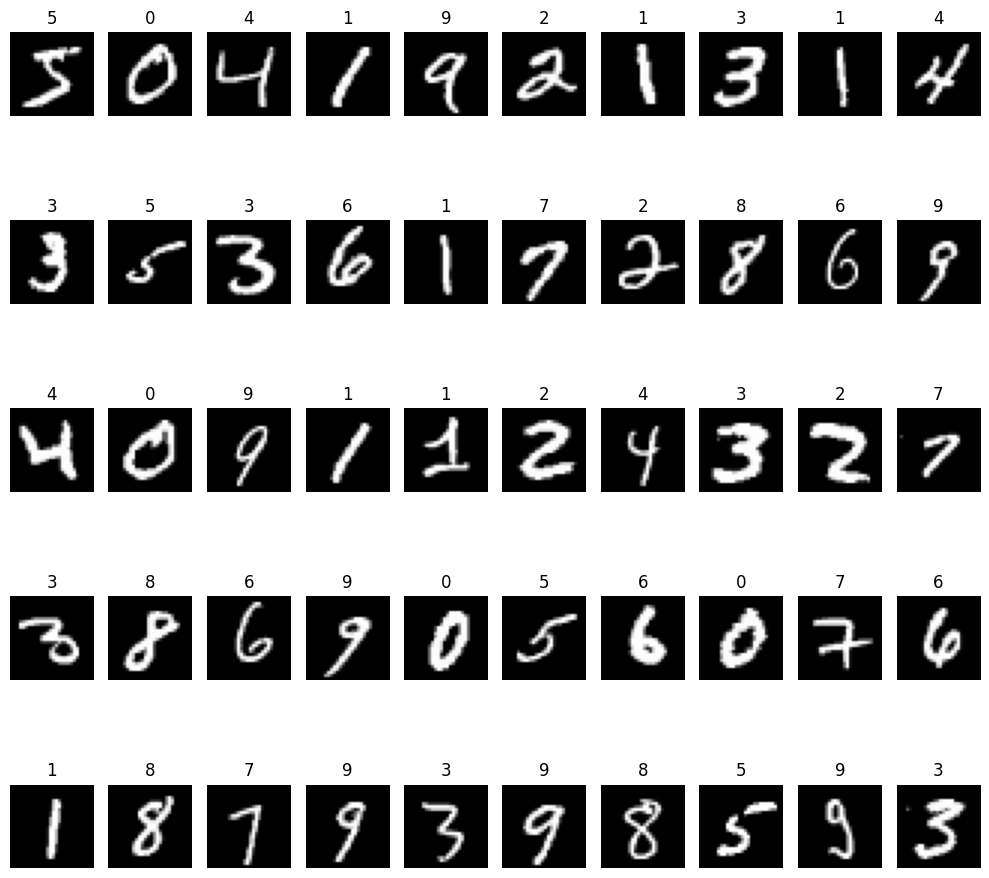

In [8]:
import matplotlib.pyplot as plt

def visualize_mnist_images(dataset, num_images=50):
    # Extract images and labels
    images, labels = zip(*[dataset[i] for i in range(num_images)])

    # Plot the images in a grid
    fig = plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = fig.add_subplot(5, 10, i + 1)
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'{labels[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the first 50 Test images from the MNIST dataset
visualize_mnist_images(train_dataset)


# smaller subset for the training dataset to speed up training

In [5]:
subset_indices = np.random.choice(len(train_dataset), int(len(train_dataset) * 0.1), replace=False)
train_subset = Subset(train_dataset, subset_indices)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Initialize the model and optimizer with a lower learning rate

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MNISTFourierKAN().to(device)
optimizer = optim.LBFGS(model.parameters(), lr=0.01)

# Training loop

Train Epoch: 1 [0/6000 (0%)]	Loss: 1.895635
Train Epoch: 1 [640/6000 (11%)]	Loss: 0.591819
Train Epoch: 1 [1280/6000 (21%)]	Loss: 0.379680
Train Epoch: 1 [1920/6000 (32%)]	Loss: 0.427797
Train Epoch: 1 [2560/6000 (43%)]	Loss: 0.338716
Train Epoch: 1 [3200/6000 (53%)]	Loss: 0.398706
Train Epoch: 1 [3840/6000 (64%)]	Loss: 0.339825
Train Epoch: 1 [4480/6000 (74%)]	Loss: 0.274986
Train Epoch: 1 [5120/6000 (85%)]	Loss: 0.312755
Train Epoch: 1 [5760/6000 (96%)]	Loss: 0.178669

Test set: Average loss: 0.3096, Accuracy: 9213/10000 (92.13%)

Train Epoch: 2 [0/6000 (0%)]	Loss: 0.147274
Train Epoch: 2 [640/6000 (11%)]	Loss: 0.113440
Train Epoch: 2 [1280/6000 (21%)]	Loss: 0.111312
Train Epoch: 2 [1920/6000 (32%)]	Loss: 0.057720
Train Epoch: 2 [2560/6000 (43%)]	Loss: 0.076271
Train Epoch: 2 [3200/6000 (53%)]	Loss: 0.328265
Train Epoch: 2 [3840/6000 (64%)]	Loss: 0.174677
Train Epoch: 2 [4480/6000 (74%)]	Loss: 0.096348
Train Epoch: 2 [5120/6000 (85%)]	Loss: 0.138274
Train Epoch: 2 [5760/6000 (96%)]	L

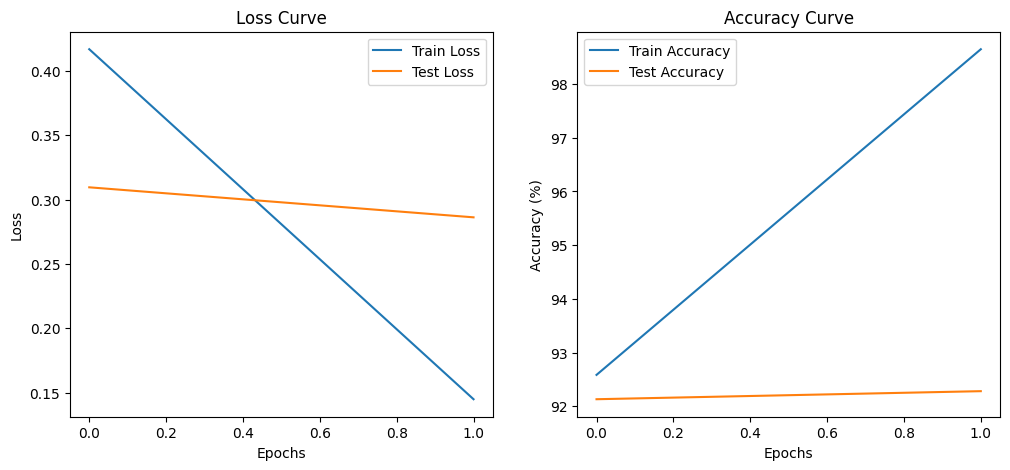

In [7]:
def train(model, device, train_loader, optimizer, epoch, train_losses, train_accuracies):
    model.train()
    correct = 0
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            loss.backward()
            return loss
        data, target = data.to(device), target.to(device)
        optimizer.step(closure)
        loss = closure()
        total_loss += loss.item()

        # Calculate accuracy
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

def test(model, device, test_loader, test_losses, test_accuracies):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss()(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_accuracy:.2f}%)\n')

# Initialize lists for tracking loss and accuracy
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Train the model
for epoch in range(1, 3):
    train(model, device, train_loader, optimizer, epoch, train_losses, train_accuracies)
    test(model, device, test_loader, test_losses, test_accuracies)

# Plot the training and test losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot the training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

# Visualise Test Data V/S Predicted Data

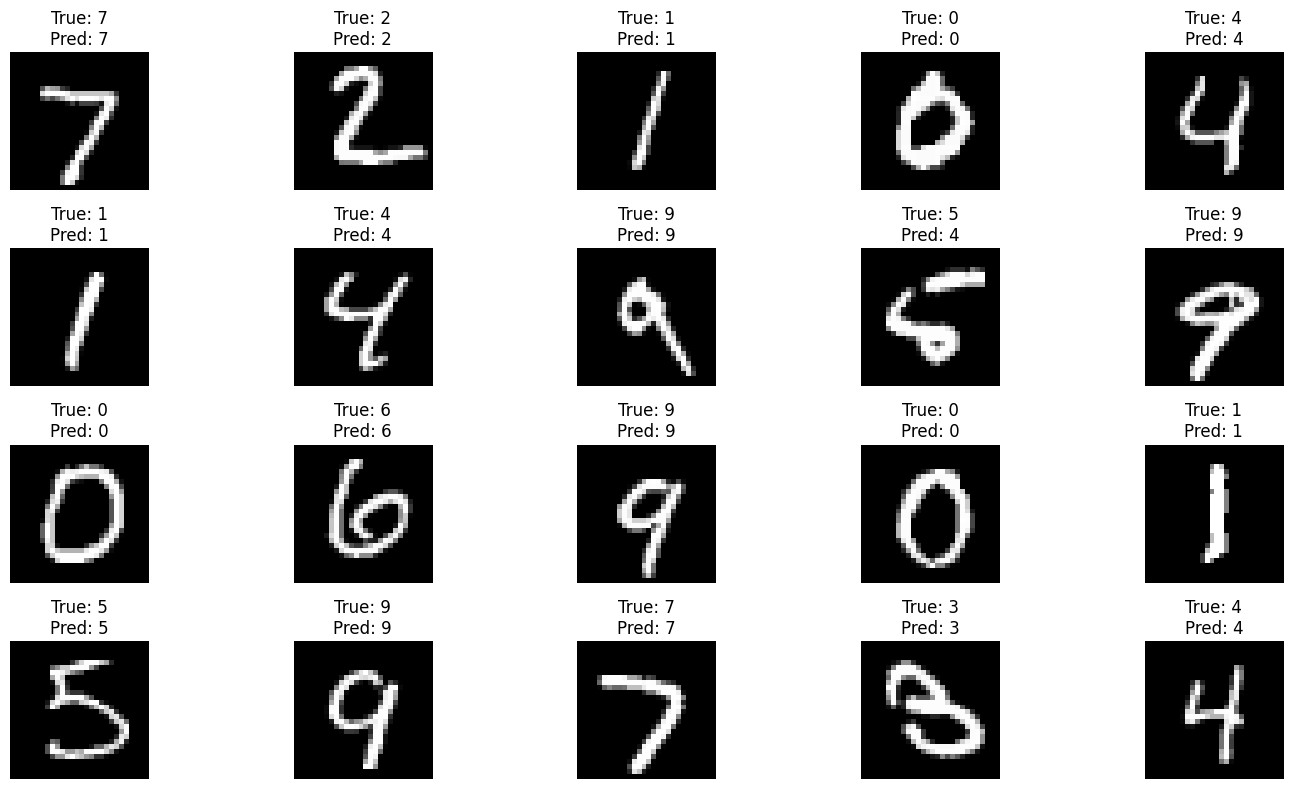

In [9]:
import torch
import matplotlib.pyplot as plt

# Function to visualize test data vs predicted data for 20 random images
def visualize_predictions(model, device, test_loader):
    model.eval()
    images, labels, predictions = [], [], []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)

            images.extend(data.cpu())
            labels.extend(target.cpu().numpy())
            predictions.extend(pred.cpu().numpy())

            if len(images) >= 20:
                break

    # Plot the results
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1)
        plt.imshow(images[i].permute(1, 2, 0).numpy(), cmap='gray')
        plt.title(f"True: {labels[i]}\nPred: {predictions[i]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_predictions(model, device, test_loader)
